# 75.68 - Sistemas de Soporte para Celdas de Producción Flexibles
## Trabajo Práctico: análisis y detección de neumonía en radiografías

Artículos:  
https://www.kaggle.com/code/madz2000/pneumonia-detection-using-cnn-92-6-accuracy/  
https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2/

Dataset:  
https://data.mendeley.com/datasets/rscbjbr9sj/3

- 79979 - Gonzalez, Juan Manuel (juagonzalez@fi.uba.ar)
- 89180 - Contini, Agustín José María (acontini@fi.uba.ar)

2C2022

## 1. Setup inicial

Importación de bibliotecas y configuraciones básicas.

In [1]:
import pandas as pd

# Configuración de parametros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib') 
pd.options.mode.chained_assignment = None

# En produccion eliminar, se incluye por informacion
print(f'Pandas Version: {pd.__version__}') 

Pandas Version: 1.5.1


In [2]:
import numpy as np

np.set_printoptions(suppress=True)

# En produccion eliminar, se incluye por informacion
print(f'Numpy version: {np.__version__}')

Numpy version: 1.21.5


In [3]:
# En produccion eliminar, se incluye por informacion
import matplotlib
print(f'Matplotlib version: {matplotlib.__version__}')

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,7)

Matplotlib version: 3.6.2


In [4]:
# Importación del resto de las librerías utilizadas
from platform import python_version
import cv2
import os
import seaborn as sns
import keras
import tensorflow as tf
from math import ceil
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.decomposition import PCA
from keras.callbacks import ReduceLROnPlateau

In [5]:
# Supresión de warnings
import warnings
warnings.filterwarnings("ignore")

In [6]:
print('\nLibrerías base__________________________________')
print('Python'.ljust(15) + ' : ' + str(python_version()))
print('Numpy'.ljust(15) + ' : ' + str(np.__version__))
print('Pandas'.ljust(15) + ' : ' + str(pd.__version__)) 
print('Tensorflow'.ljust(15) + ' : ' + str(tf.__version__))
print('\nLibrerías jupyter_______________________________')
bfJuppyter = !jupyter --version
for bfPackages in bfJuppyter:
    if bfPackages.count('Selected Jupyter')==0:
        arPackages = bfPackages.split(':')
        print(arPackages[0].strip().capitalize().ljust(15) + ' :' + arPackages[1]) 
print('________________________________________________\n')   


Librerías base__________________________________
Python          : 3.9.15
Numpy           : 1.21.5
Pandas          : 1.5.1
Tensorflow      : 2.8.0

Librerías jupyter_______________________________
Ipython         : 8.6.0
Ipykernel       : 5.5.5
Ipywidgets      : 8.0.2
Jupyter_client  : 7.3.4
Jupyter_core    : 4.11.2
Jupyter_server  : 1.23.2
Jupyterlab      : 3.5.0
Nbclient        : 0.7.0
Nbconvert       : 7.2.5
Nbformat        : 5.7.0
Notebook        : 6.5.2
Qtconsole       : not installed
Traitlets       : 5.5.0
________________________________________________



## 2. Descripción del dataset y carga de los datos

### 2.1 Dataset utilizado

El dataset utilizado se encuentra disponible en Mendeley, en su versión 3:  

**Large Dataset of Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images**  
*Kermany D, Goldbaum M, Cai W et al. Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning. Cell. 2018; 172(5):1122-1131. doi:10.1016/j.cell.2018.02.010*

Este dataset contiene miles de tomografías de coherencia óptica (OCT) y placas de Rayos-X de pecho que han sido validadas. La fuente son la University of California San Diego, y el Guangzhou Women and Children's Medical Center. Las imágenes se encuentran nombradas como (enfermedad)-(ID de paciente aleatorio)-(número de imagen del paciente).

En particular, para este trabajo, tomaremos únicamente las placas de pecho (suman 5856 imágenes), que han sido clasificadas entre normales, neumonía de origen viral y neumonía de origen bacteriano.

Se trabajará solamente con dos clases: **NORMAL** y **NEUMONIA**.

### 2.2. Carga de los datos

El dataset de radiografías de pecho que hemos utilizado ya divide los archivos en train, val y test, con muy pocos archivos en el directorio de validación. Para este trabajo, uniremos todos los arhivos y crearemos un split 80:20 estándar, luego de realizar el análisis exploratorio.

In [7]:
# Definición de labels, y tamaño de imagen a utilizar
labels = ['NORMAL', 'PNEUMONIA']
img_size = 150

In [8]:
# Leemos los datos de las 3 carpetas proporcionadas en el dataset
# Las imágenes las almacenamos como matrices de enteros: cada posición representa
# el valor de intensidad del píxel en escala de grises [0, 255]
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        # class_num = identificación de targets o clases (0 es normal y 1 es neumonía)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                # Las imágenes son resampleadas al tamaño especificado
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

train_dir = get_data('../chest_xray/train')
test_dir = get_data('../chest_xray/test')
val_dir = get_data('../chest_xray/val')

In [9]:
# Vemos la longitud de cada uno
print('Cantidad de imágenes en directorio "train": ' + str(len(train_dir)))
print('Cantidad de imágenes en directorio "test": ' + str(len(test_dir)))
print('Cantidad de imágenes en directorio "val": ' + str(len(val_dir)))

Cantidad de imágenes en directorio "train": 5216
Cantidad de imágenes en directorio "test": 624
Cantidad de imágenes en directorio "val": 16


## 3. Visualización de los Datos

Si bien contamos con un dataset de imágenes, realizaremos un breve análisis exploratorio para entender las características generales de los datos.

In [10]:
# Separamos las imágenes de cada clase en dos listas, para el directorio "train"
normal_images = []
pneumonia_images = []
l = []

for i in train_dir:
    if i[1] == 0:
        normal_images.append(i[0])
        l.append("Normal")
    else:
        pneumonia_images.append(i[0])
        l.append("Pneumonia")

print('Cantidad de imágenes con clase 0 (NORMAL): ' + str(len(normal_images)))
print('Cantidad de imágenes con clase 1 (PNEUMONIA): ' + str(len(pneumonia_images)))

Cantidad de imágenes con clase 0 (NORMAL): 1341
Cantidad de imágenes con clase 1 (PNEUMONIA): 3875


### 3.1. Distribución de clases

<AxesSubplot: ylabel='Count'>

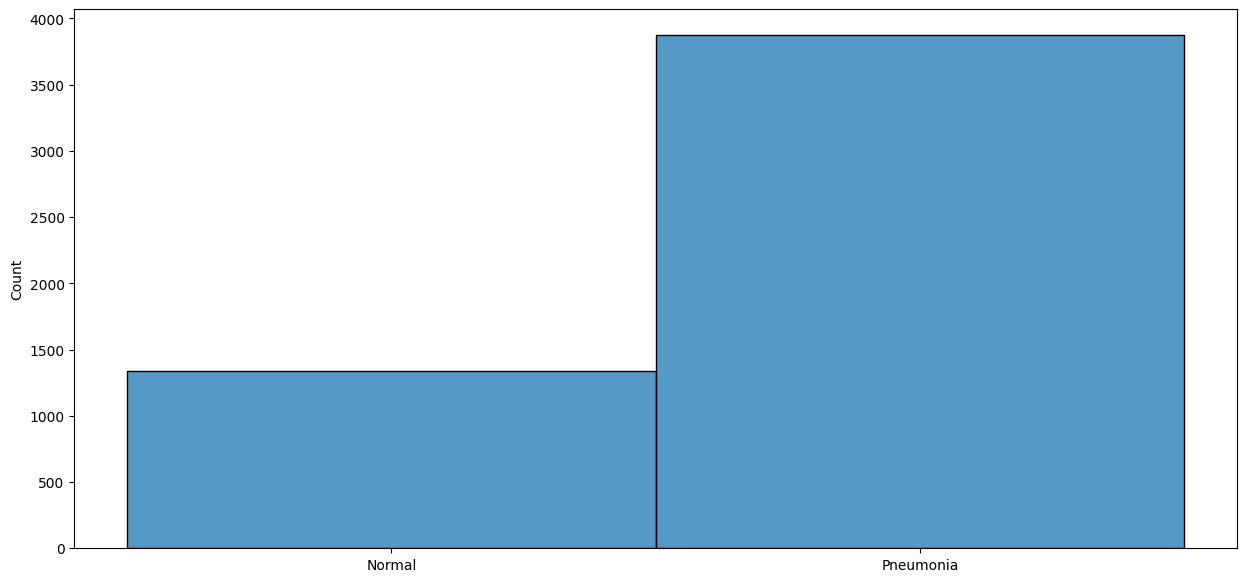

In [11]:
# Investigamos la distribución de las imágenes en el set de entrenamiento
sns.histplot(l)

Hay mas imágenes clasificadas como neumonía que normales, por lo que tenemos un dataset desbalanceado.

### 3.2. Visualización de imágenes de ejemplo

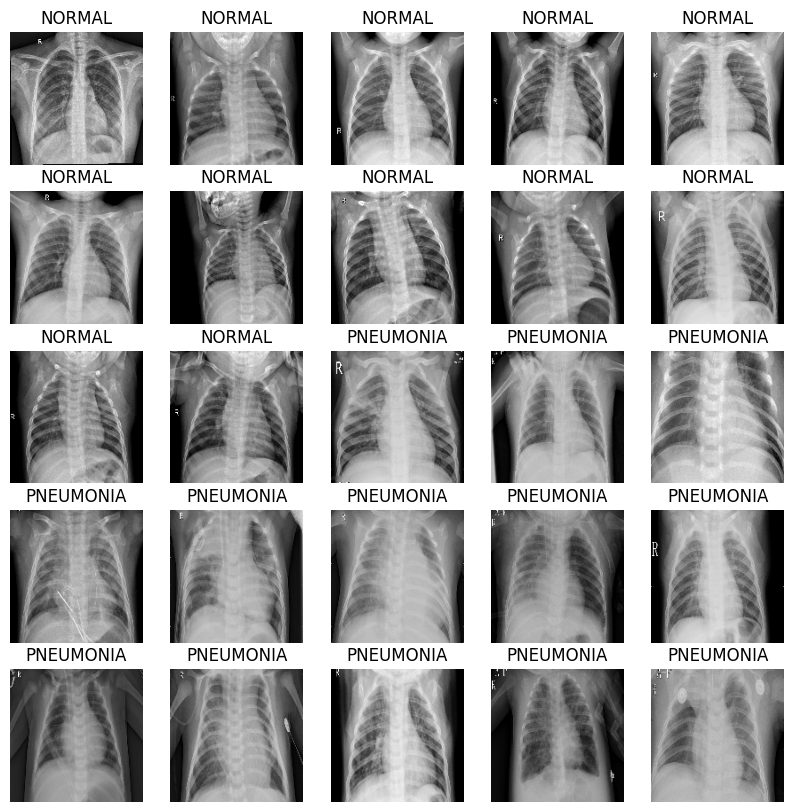

In [12]:
# Mostramos un batch de imagenes del dataset
img_to_show = 25

def show_batch(normal_images, pneumonia_images):

    plt.figure(figsize=(10,10))
    for n in range(int(img_to_show/2)):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(normal_images[n], cmap='gray')
        plt.title("NORMAL")
        plt.axis("off")
    for n in range(int(img_to_show/2), img_to_show):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(pneumonia_images[n], cmap='gray')
        plt.title("PNEUMONIA")
        plt.axis("off")
        
show_batch(normal_images, pneumonia_images)

### 3.3. Imgágenes media y de desviación estándar

Vamos a calcular la imagen media y de desviación estándar para cada clase. Para lograrlo, trabajamos con los valores de intensidad de cada píxel en todas las observaciones.

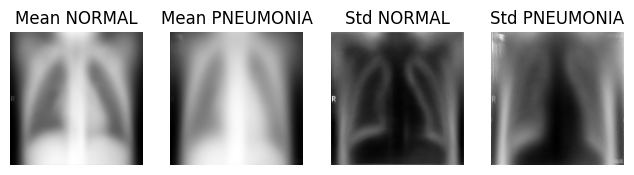

In [13]:
# Calculamos la media y desviación standard de ambas clases
def find_mean_img(full_mat):
    mean_img = np.mean(full_mat, axis = 0)
    return mean_img

def find_std_img(full_mat):
    std_img = np.std(full_mat, axis = 0)
    return std_img

norm_mean = find_mean_img(normal_images)
pneu_mean = find_mean_img(pneumonia_images)
norm_std = find_std_img(normal_images)
pneu_std = find_std_img(pneumonia_images)

images = [[norm_mean, 'Mean NORMAL'], [pneu_mean, 'Mean PNEUMONIA'], [norm_std, 'Std NORMAL'], [pneu_std, 'Std PNEUMONIA']]

plt.figure(figsize=(10,10))
for n in range(len(images)):
    ax = plt.subplot(5,5,n+1)
    plt.imshow(images[n][0], cmap='gray')
    plt.title(images[n][1])
    plt.axis('off')

Las medias nos muestran que las placas clasificadas como neumonía tienden a mostrar mayor obstrucción en la zona del pecho. Asismimo, podemos ver en las imágenes de desviación estándar que la mayor variabilidad (zonas claras) se da en la zona de los pulmones.

### 3.4. Diferencia con contraste entre las imágenes medias

Una prueba interesante consiste en calcular la diferencia, aplicando un contraste, entre las imágenes medias de cada clase, calculadas en la sección anterior. En este caso podemos ver que las mayores diferencias (zonas rojas) se dan en la zona de los pulmones.

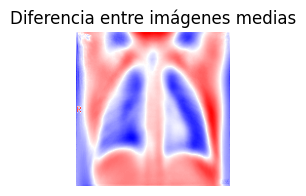

In [14]:
# Difrencia con contraste para ambos caos
contrast_mean = norm_mean - pneu_mean

plt.figure(figsize=(2,2))
plt.imshow(contrast_mean, cmap='bwr')
plt.title('Diferencia entre imágenes medias')
plt.axis('off')
plt.show()

### 3.5. Autoimágenes

Finalmente, podemos utilizar una técnica de reducción de dimenciones, como por ejemplo PCA (principal component analysis) para visualizar los componentes que mejor describen cada clase. Estas "autoimágenes", que son en realidad los autovectores de nuestra matriz, pueden ser transformados a una matriz y ploteados. Esta técnica se uilizó por primera vez para reconocimiento facial.

Mostraremos aquí los componentes que describen un 70% de variablidad para cada clase.

In [15]:
def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC (' + str(title) + '): ' + str(pca.n_components_))
    return pca

np_normal_images = np.array(normal_images)
nsamples, nx, ny = np_normal_images.shape
d2_normal_images = np_normal_images.reshape((nsamples,nx*ny))
d2_normal_images_ein = eigenimages(d2_normal_images, 'NORMAL')

np_pneumonia_images = np.array(pneumonia_images)
nsamples, nx, ny = np_pneumonia_images.shape
d2_pneumonia_images = np_pneumonia_images.reshape((nsamples,nx*ny))
d2_pneumonia_images = eigenimages(d2_pneumonia_images, 'PNEUMONIA')

Number of PC (NORMAL): 27
Number of PC (PNEUMONIA): 14


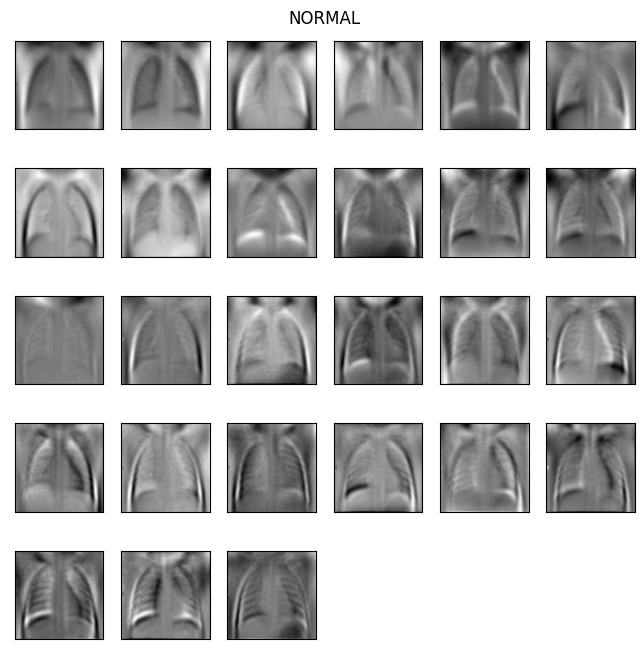

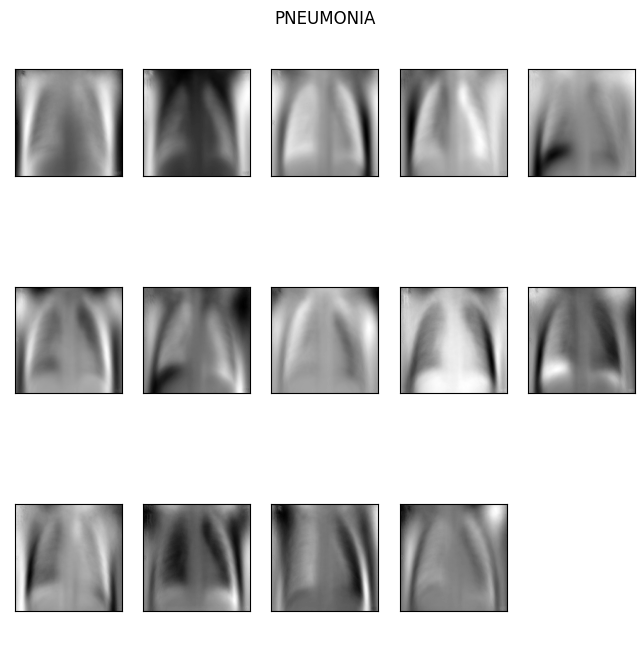

In [16]:
def plot_pca(pca, title):
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    plt.title(title)
    plt.axis('off')
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape((img_size, img_size)), cmap='gray')
    plt.show()
    
plot_pca(d2_normal_images_ein, 'NORMAL')
plot_pca(d2_pneumonia_images, 'PNEUMONIA')

Podemos observar que las autoimágenes de las placas sanas muestran mucha más definicion alrededor de las costillas y los organos, comparados con la clase perteneciente a observaciones clasificacadas como neumonía.

## 4. Preparación de los Datos

En esta sección nos encargamos de preparar los datos para el proceso de entrenamiento, realizando diversas transformaciones y operaciones.

### 4.1. Unificación y Split  80/20

Realizamos la unión de los archivos y luego hacemos el split mediante sklearn. Acto seguido, preparamos series para utilizar con la red neuronal, separando los targets de las imágenes.

In [17]:
# Unimos ambos directorios y hacemos el split mediante sklearn
#train_test = train_dir + test_dirtrain_test = train_dir + test_dir
train_test = [*train_dir, *test_dir]
train, test = train_test_split(train_test, test_size=0.2)
# No tocamos el set de validacion
val = val_dir

In [18]:
# Vemos la longitud de cada uno
print('Cantidad de imágenes en set "train": ' + str(len(train)))
print('Cantidad de imágenes en set "test": ' + str(len(test)))
print('Cantidad de imágenes en set "val": ' + str(len(val)))

Cantidad de imágenes en set "train": 4672
Cantidad de imágenes en set "test": 1168
Cantidad de imágenes en set "val": 16


In [19]:
# Separamos las imágenes de los valores de los targets:
# x = imagenes
# y = targets o clases (0 es normal y 1 es neumonía)

x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

### 4.2. Normalización y aumento de los datos

Normalizamos los valores de intensidad de los píxeles, entre 0 y 1, para su uso con la red neuronal.

Usamos real-time data generator de tensor flow, para generar imágenes y prevenir el overfitting al utilizar las variaciones en forma automática en cada epoch. Introducimos zoom, rotaciones y desplazamientos en ancho y alto solamente, dado que las otras opciones alteran las placas de una manera que harían que no fueran analizables (por ejemplo un flip o imagen especular).

In [20]:
# Normalizamos los valores de intensidad de los píxeles, entre 0 y 1, para su uso con la red neuronal
x_train = np.array(x_train)/255
x_val = np.array(x_val)/255
x_test = np.array(x_test)/255

In [21]:
# Aumento de los datos
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip = True,
        vertical_flip=False)

datagen.fit(x_train)

### 4.3. Corrección de desbalance en el dataset

In [22]:
# Contamos en el set de train, cuantos casos hay de cada clase
count_normal = 0
count_pneumonia = 0

for i in train:
    if i[1] == 0:
        count_normal = count_normal + 1
    else:
        count_pneumonia = count_pneumonia + 1
        
print('Cantidad de imágenes con clase 0 (NORMAL): ' + str(count_normal))
print('Cantidad de imágenes con clase 1 (PNEUMONIA): ' + str(count_pneumonia))

Cantidad de imágenes con clase 0 (NORMAL): 1285
Cantidad de imágenes con clase 1 (PNEUMONIA): 3387


In [23]:
initial_bias = np.log(count_pneumonia/count_normal)
print('Bias inicial: ' + str(initial_bias))

Bias inicial: 0.9691858554884515


In [24]:
weight_for_0 = (1/len(normal_images))*(len(train))/2.0 
weight_for_1 = (1/len(pneumonia_images))*(len(train))/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Peso para la clase 0 (NORMAL): {:.2f}'.format(weight_for_0))
print('Peso para la clase 1 (PNEUMONIA): {:.2f}'.format(weight_for_1))

Peso para la clase 0 (NORMAL): 1.74
Peso para la clase 1 (PNEUMONIA): 0.60


## 5. Construcción del modelo y entrenamiento

Construimos una red neuronal profunda mediante la definición de un modelo secuencial implementado en Keras.

### 5.1. Construcción del modelo

Contamos como input con una capa de Conv2D de Keras, y como salida una capa densa de 1D, ya que tenemos que clasificar 2 posibles categorías. Las capas ocultas que forman esta red profunda están capas de convolucion, mormalización, maxpooling y dropout intercaladas, estas últimas a fin de prevenir overfitting. Como algoritmo de optimización utilizamos "rmsprop", y la función de loss es "binary_crossentropy." Las métricas utilizadas son "accuracy", "precision" y "recall".

In [25]:
# Construimos el modelo de la CNN a utilizar
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (img_size,img_size,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

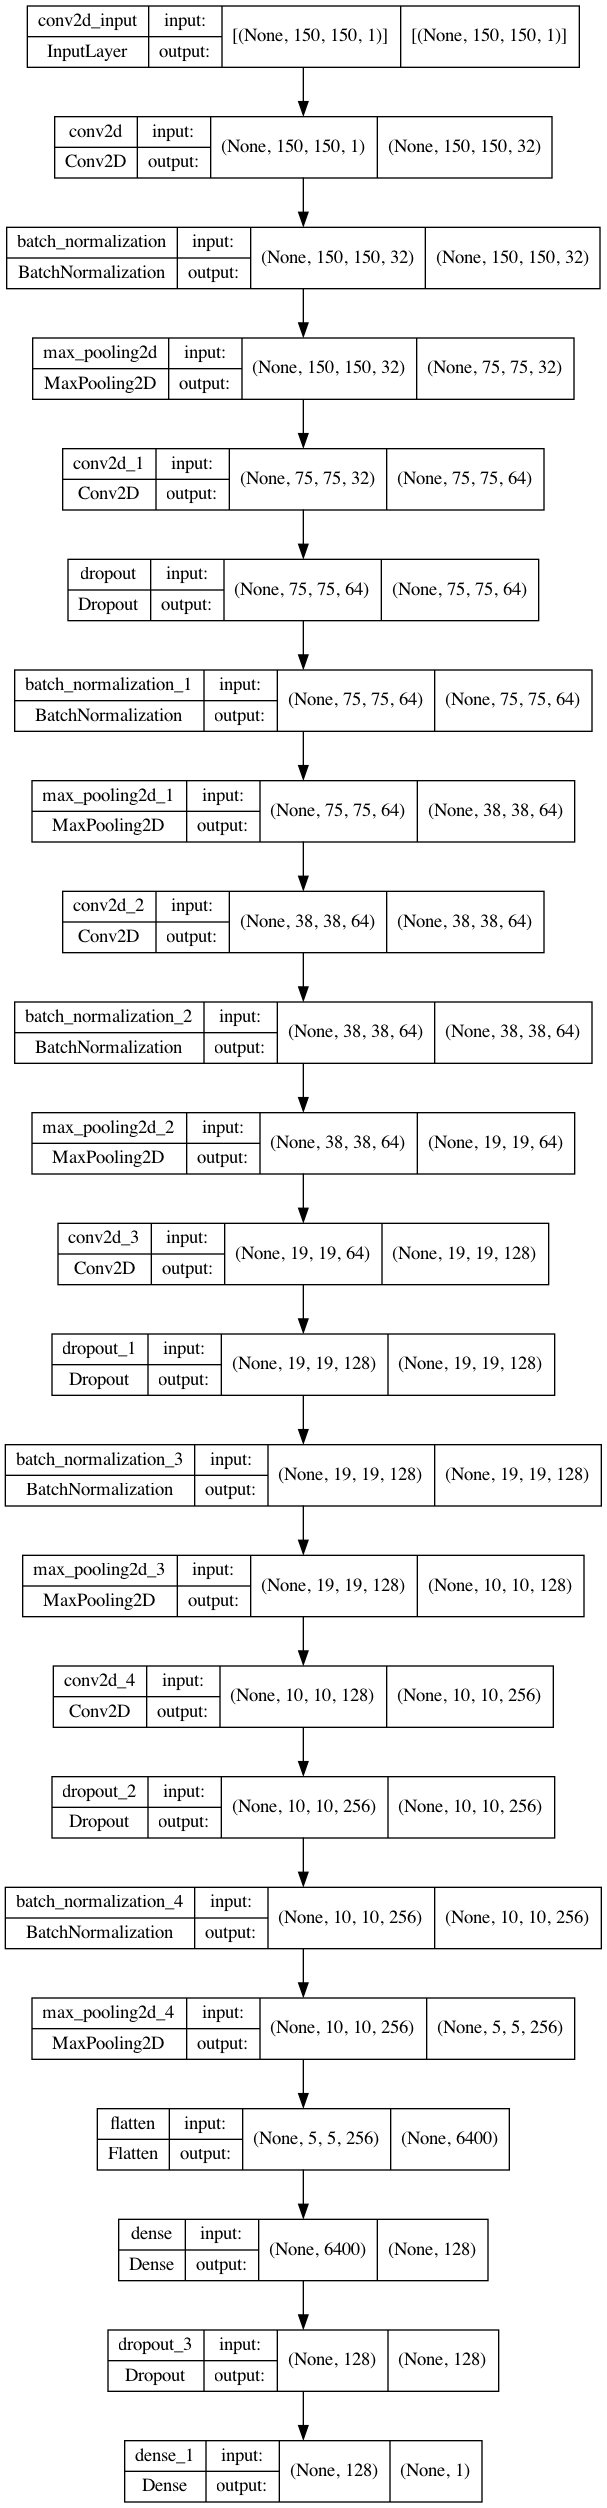

In [26]:
# Lo vemos en forma gráfica
plot_model(model, show_shapes=True, show_layer_names=True)

### 5.2. Entrenamiento

Se realiza el entrenamiento de la CNN con el set de train, test y validación definidos anteriormente.

In [27]:
# ACA SE PRODRIA PONER GRID SERACH O ALGO ASI PARA TUNEAR HIPERPARAMETROS
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = [img_size, img_size]
EPOCHS = 25

In [28]:
# Definición de callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("pneumonia_model.h5", save_best_only=True)

# Saco temp que queda bajo
# early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [29]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)
# learning_rate_reduction = ReduceLROnPlateau(
#     monitor='val_accuracy',
#     patience = 2,
#     verbose=1,
#     factor=0.3,
#     min_lr=0.000001
#)
learning_rate_reduction = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [38]:
# Entrenamos la red
history = model.fit(
    datagen.flow(x_train, y_train, batch_size = BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=datagen.flow(x_test, y_test),
    class_weight=class_weight,
    callbacks = [checkpoint_callback, learning_rate_reduction] # early_stopping_callback
)

Epoch 1/25
146/146 [==============================] - 34s 235ms/step - loss: 0.6446 - accuracy: 0.8472 - precision: 0.9258 - recall: 0.8580 - val_loss: 9.0054 - val_accuracy: 0.2611 - val_precision: 1.0000 - val_recall: 0.0171 - lr: 0.0100
Epoch 2/25
146/146 [==============================] - 34s 230ms/step - loss: 0.3806 - accuracy: 0.8664 - precision: 0.9446 - recall: 0.8665 - val_loss: 0.7138 - val_accuracy: 0.8305 - val_precision: 0.8301 - val_recall: 0.9738 - lr: 0.0089
Epoch 3/25
146/146 [==============================] - 35s 238ms/step - loss: 0.3072 - accuracy: 0.8851 - precision: 0.9532 - recall: 0.8849 - val_loss: 1.7868 - val_accuracy: 0.5873 - val_precision: 0.9177 - val_recall: 0.4954 - lr: 0.0079
Epoch 4/25
146/146 [==============================] - 36s 244ms/step - loss: 0.2869 - accuracy: 0.8863 - precision: 0.9554 - recall: 0.8846 - val_loss: 0.4951 - val_accuracy: 0.7937 - val_precision: 0.7846 - val_recall: 1.0000 - lr: 0.0071
Epoch 5/25
146/146 [====================

## 6. Validación y análisis de resultados

En esta sección evaluamos los resultados obtenidos.

### 6.1. Performance obtenida

Graficamos asimismo las cuatro métricas calculadas durante el entrenamiento. Imprimimos las dos métricas principales, loss y accuracy para el set de validación.

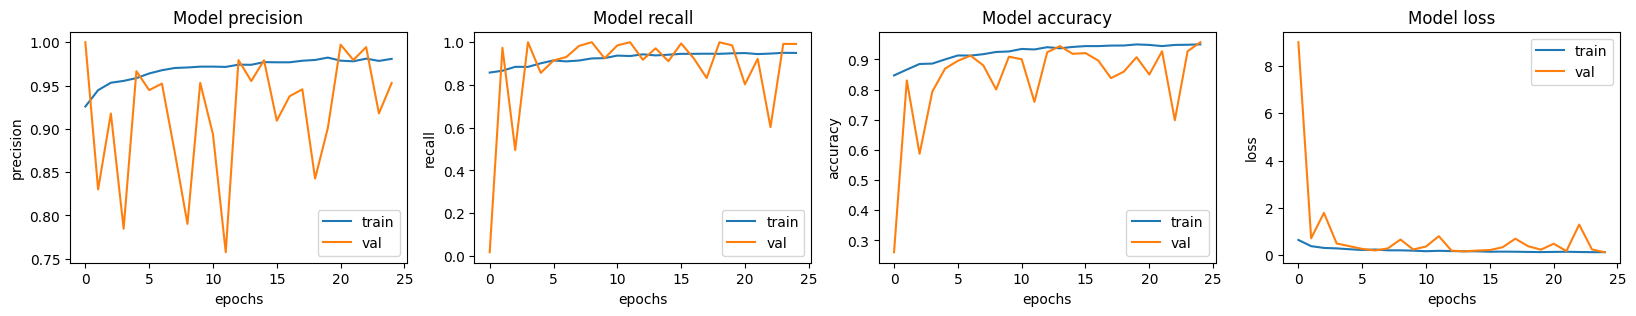

In [39]:
# Graficamos las métricas obtenidas
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [41]:
# Mostramos las métricas de loss y accuracy
print("Loss de modelo - " , model.evaluate(x_train,y_train)[0])
print("Accuracy del modelo - " , model.evaluate(x_train,y_train)[1]*100 , "%")

146/146 [==============================] - 7s 48ms/step - loss: 0.1172 - accuracy: 0.9636 - precision: 0.9849 - recall: 0.9646
Loss de modelo -  0.11722200363874435
146/146 [==============================] - 7s 48ms/step - loss: 0.1172 - accuracy: 0.9636 - precision: 0.9849 - recall: 0.9646
Accuracy del modelo -  96.36130332946777 %


### 6.2. Reporte de clasificación y matriz de confusión

Analizamos en esta sección cómo ha clasificado la red, tanto en términos de clasificaciones correctas como incorrectas.

In [42]:
# Calculamos el reporte de clasificación
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]

print(classification_report(y_test, predictions, target_names = ['Normal (Class 0)', 'Pneumonia (Class 1)']))

                     precision    recall  f1-score   support

   Normal (Class 0)       0.87      0.94      0.90       290
Pneumonia (Class 1)       0.98      0.95      0.97       878

           accuracy                           0.95      1168
          macro avg       0.92      0.95      0.94      1168
       weighted avg       0.95      0.95      0.95      1168



<AxesSubplot: >

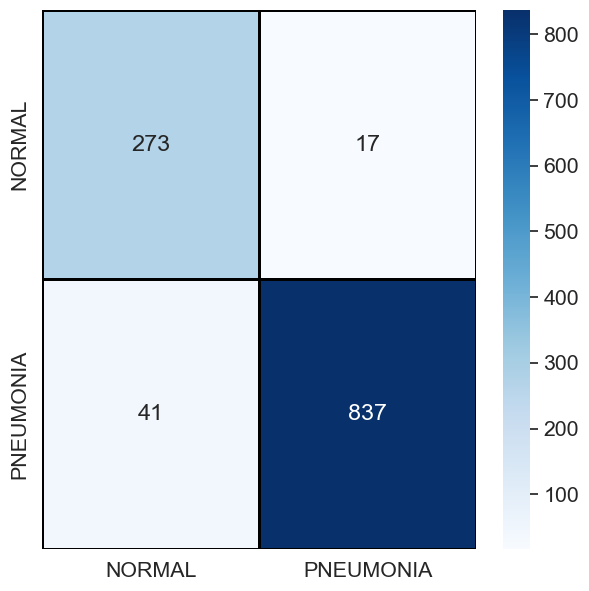

In [43]:
# Calculamos la matriz de confusión
cm = confusion_matrix(y_test, predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

plt.figure(figsize = (7,7))
sns.set(font_scale=1.4)
sns.heatmap(cm,cmap= "Blues", linecolor = 'black', linewidth = 1, annot = True, fmt='', xticklabels = labels, yticklabels = labels)

### 6.3. Ejemplos de casos mal clasificados

A fin de poder visualizar mejor los casos mal clasificados, se muestran algunos ejemplos. Sería interesante contar con una opinión experta que permita discernir si se trata de casos de borde o la red ha clasificado mal casos obvios, como para entender mejor el comportamiento obtenido para estos casos.

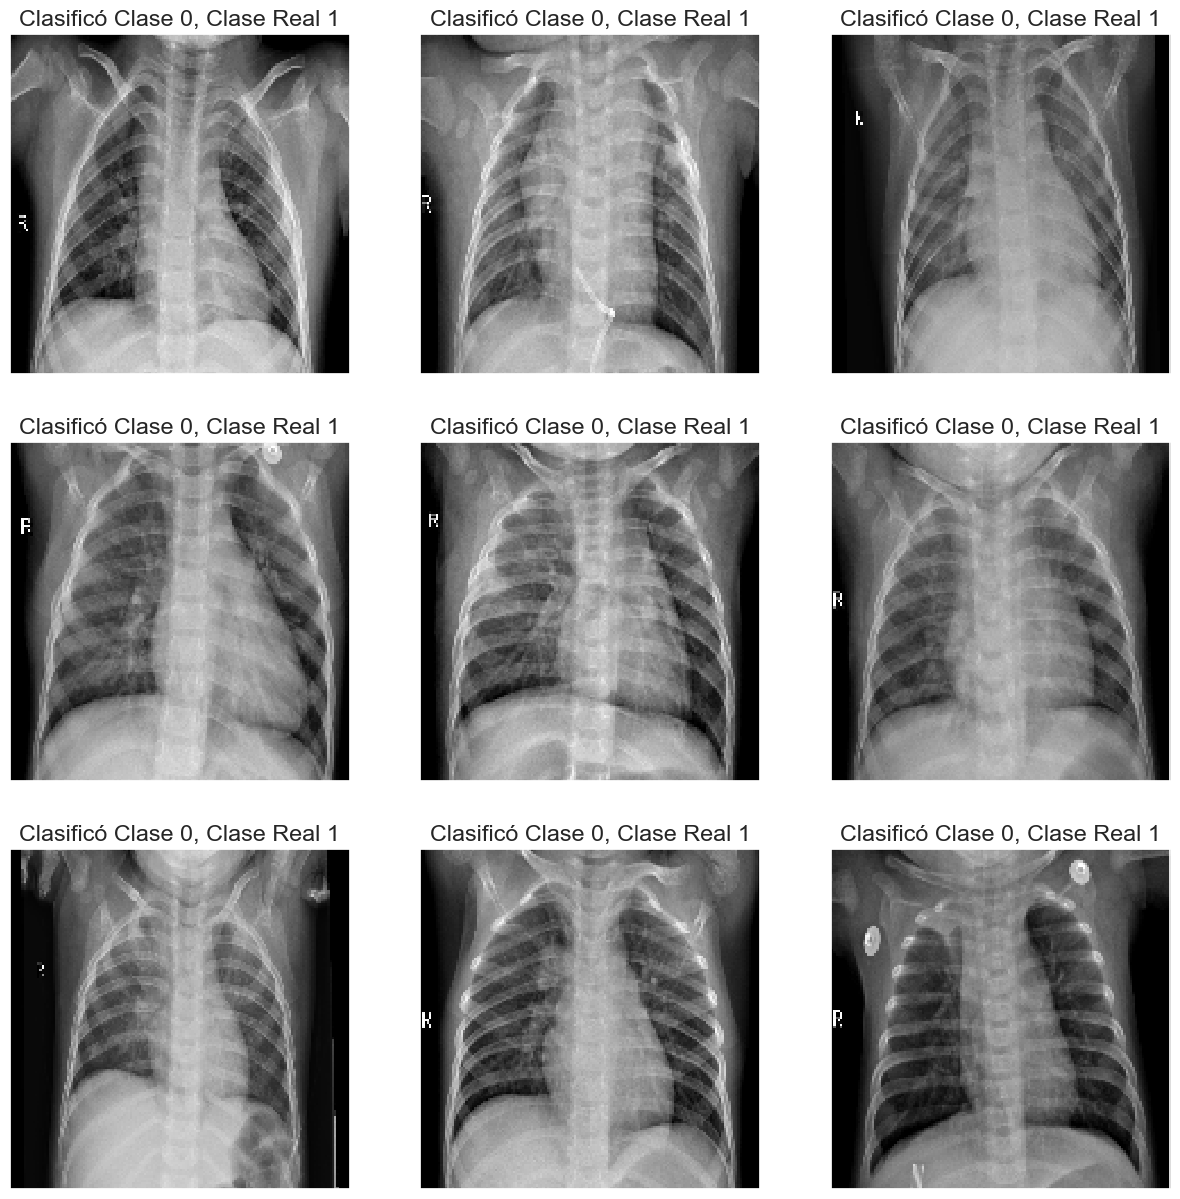

In [44]:
# Mostramos algunos de los casos mal clasificados
incorrect = np.nonzero(predictions != y_test)[0]
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
for i in range(3):
    for j in range(3):
        axs[i, j].set_yticks([])
        axs[i, j].set_xticks([])
        axs[i, j].imshow(x_test[incorrect[3*i+j]].reshape(150,150), cmap="gray", interpolation='none')
        axs[i, j].set_title("Clasificó Clase {}, Clase Real {}".format(predictions[incorrect[3*i+j]], y_test[incorrect[3*i+j]]))